# Lab2 DeepConvNet

In [1]:
import os
import torch
print(torch.__version__)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from dataloader import read_bci_data

1.4.0
cuda


## TensorDataset & DataLoader

In [2]:
X_train,y_train,X_test,y_test=read_bci_data()
dataset=TensorDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))
loader_train=DataLoader(dataset,batch_size=64)
dataset=TensorDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))
loader_test=DataLoader(dataset,batch_size=64)
print(f'test dataset:\n{dataset[:3]}')

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
test dataset:
(tensor([[[[ -8.3359,  -8.7829,  -9.3748,  ...,  -2.1328,  -2.8224,  -2.0885],
          [-10.6524,  -8.4476,  -5.9331,  ...,   0.5607,  -4.1266,  -8.1379]]],


        [[[ -1.6904,  -3.2816,  -3.6523,  ...,   4.0093,   0.7018,   0.7155],
          [  3.4033,   2.0698,  -1.6959,  ...,   7.7458,   3.5498,   3.7207]]],


        [[[ -2.6835,  -0.4836,   1.9848,  ...,  -3.9513,   0.4729,   5.2923],
          [  2.6602,   3.9587,   4.9871,  ...,  -0.6675,  -0.2266,   0.0633]]]],
       dtype=torch.float64), tensor([1., 0., 1.], dtype=torch.float64))


sample_id:28


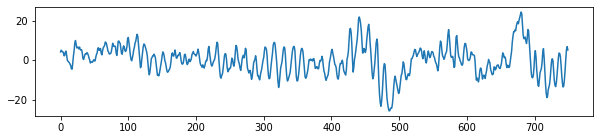

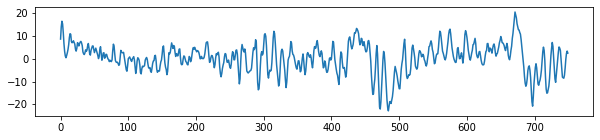

In [3]:
randi=int(np.random.randint(0,X_train.shape[0],1))
print(f'sample_id:{randi}')
plt.figure(figsize=(10,2))
plt.plot(X_train[randi,0,0])
plt.figure(figsize=(10,2))
plt.plot(X_train[randi,0,1])

## Model
![deepConvNet](deepconvnet.png)  

In [4]:
class DeepConvNet(nn.Module):
    def __init__(self,activation=nn.ELU()):
        super(DeepConvNet,self).__init__()
        self.conv0=nn.Conv2d(1,25,kernel_size=(1,5))
        channels=[25,25,50,100,200]
        kernel_sizes=[None,(2,1),(1,5),(1,5),(1,5)]
        for i in range(1,len(channels)):
            setattr(self,'conv'+str(i),nn.Sequential(
                nn.Conv2d(channels[i-1],channels[i],kernel_size=kernel_sizes[i]),
                nn.BatchNorm2d(channels[i],eps=1e-5,momentum=0.1),
                activation,
                nn.MaxPool2d(kernel_size=(1,2)),
                nn.Dropout(p=0.5)
            ))
        self.classify=nn.Linear(8600,2)
    def forward(self,X):
        out=self.conv0(X)
        out=self.conv1(out)
        out=self.conv2(out)
        out=self.conv3(out)
        out=self.conv4(out)
        out=out.view(out.shape[0],-1)
        neurons=out.shape[0]
        out=self.classify(out)
        return out

## Train
__loss function:__ cross entropy  
__optimizer:__ adam  
__learning rate:__ 0.001  
__epoch:__ 300  
__batch_size:__ 64  
__activation fuction:__ ReLU,LeakyReLU,ELU  

In [5]:
Loss=nn.CrossEntropyLoss()
lr=0.001
epochs=300

In [6]:
def train_with_different_activation(loader_train,loader_test,activations,device):
    """
    Args:
        loader_train: training dataloader
        loader_test: testing dataloader
        activations: {ReLU,LeakyReLU,ELU} pytorch layer
        device: pytorch device gpu,cpu
    Return:
        dataframe: with column 'epoch','ReLU_train','ReLU_test','LeakyReLU_train'...
    """
    df=pd.DataFrame()
    df['epoch']=range(1,epochs+1)
    for name,activation in activations.items():
        """
        train model with an specific activation function
        """
        model=DeepConvNet(activation)
        model.to(device)
        optimizer=torch.optim.Adam(model.parameters(),lr=lr)
        acc_train=list()
        acc_test=list()
        for epoch in range(1,epochs+1):
            """
            train
            """
            model.train()
            loss=0
            correct=0
            for idx,(data,target) in enumerate(loader_train):
                data=data.to(device,dtype=torch.float)
                target=target.to(device,dtype=torch.long) #target type has to be 'long'
                predict=model(data)
                loss+=Loss(predict,target)
                correct+=predict.max(dim=1)[1].eq(target).cpu().sum()
                """
                update
                """
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()
            loss/=len(loader_train.dataset)
            correct=100.*correct/len(loader_train.dataset)
            print(f'epcoh{epoch:>3d}  loss:{loss:.4f}  acc:{correct:.1f}%')
            acc_train.append(correct)
            """
            test
            """
            model.eval()
            correct=0
            for idx,(data,target) in enumerate(loader_test):
                data=data.to(device,dtype=torch.float)
                target=target.to(device,dtype=torch.long)
                predict=model(data)
                correct+=predict.max(dim=1)[1].eq(target).cpu().sum()
            correct=100.*correct/len(loader_test.dataset)
            acc_test.append(correct)
        df[name+'_train']=acc_train
        df[name+'_test']=acc_test
        torch.save(model.state_dict(),os.path.join('deepconvnet models',name+'.pt'))
    return df

In [7]:
activations={'ReLU':nn.ReLU(),'LeakyReLU':nn.LeakyReLU(),'ELU':nn.ELU()}
df=train_with_different_activation(loader_train,loader_test,activations,device)

epcoh  1  loss:0.0700  acc:49.9%
epcoh  2  loss:0.1652  acc:50.6%
epcoh  3  loss:0.4345  acc:50.0%
epcoh  4  loss:0.1528  acc:52.3%
epcoh  5  loss:0.2070  acc:50.1%
epcoh  6  loss:0.1829  acc:52.3%
epcoh  7  loss:0.0648  acc:52.1%
epcoh  8  loss:0.1406  acc:50.4%
epcoh  9  loss:0.1520  acc:50.4%
epcoh 10  loss:0.0666  acc:53.2%
epcoh 11  loss:0.0670  acc:51.8%
epcoh 12  loss:0.1122  acc:49.9%
epcoh 13  loss:0.1328  acc:50.6%
epcoh 14  loss:0.0681  acc:54.4%
epcoh 15  loss:0.0503  acc:51.8%
epcoh 16  loss:0.0601  acc:52.3%
epcoh 17  loss:0.0870  acc:51.9%
epcoh 18  loss:0.0954  acc:52.6%
epcoh 19  loss:0.0420  acc:52.7%
epcoh 20  loss:0.0486  acc:57.0%
epcoh 21  loss:0.0606  acc:52.1%
epcoh 22  loss:0.0870  acc:51.5%
epcoh 23  loss:0.0819  acc:56.9%
epcoh 24  loss:0.0393  acc:55.6%
epcoh 25  loss:0.0560  acc:53.5%
epcoh 26  loss:0.0650  acc:52.2%
epcoh 27  loss:0.0631  acc:57.9%
epcoh 28  loss:0.0325  acc:64.4%
epcoh 29  loss:0.0322  acc:57.3%
epcoh 30  loss:0.0521  acc:60.3%
epcoh 31  

epcoh250  loss:0.0050  acc:86.7%
epcoh251  loss:0.0045  acc:88.5%
epcoh252  loss:0.0047  acc:88.1%
epcoh253  loss:0.0045  acc:87.7%
epcoh254  loss:0.0044  acc:88.9%
epcoh255  loss:0.0037  acc:90.7%
epcoh256  loss:0.0038  acc:90.5%
epcoh257  loss:0.0043  acc:90.7%
epcoh258  loss:0.0038  acc:89.6%
epcoh259  loss:0.0040  acc:89.4%
epcoh260  loss:0.0041  acc:88.7%
epcoh261  loss:0.0040  acc:89.9%
epcoh262  loss:0.0036  acc:91.0%
epcoh263  loss:0.0042  acc:90.3%
epcoh264  loss:0.0042  acc:90.3%
epcoh265  loss:0.0040  acc:90.4%
epcoh266  loss:0.0038  acc:90.6%
epcoh267  loss:0.0038  acc:91.0%
epcoh268  loss:0.0041  acc:90.5%
epcoh269  loss:0.0050  acc:88.5%
epcoh270  loss:0.0063  acc:86.0%
epcoh271  loss:0.0069  acc:86.2%
epcoh272  loss:0.0060  acc:84.8%
epcoh273  loss:0.0062  acc:85.6%
epcoh274  loss:0.0053  acc:86.8%
epcoh275  loss:0.0054  acc:86.8%
epcoh276  loss:0.0039  acc:90.7%
epcoh277  loss:0.0041  acc:89.8%
epcoh278  loss:0.0053  acc:88.2%
epcoh279  loss:0.0056  acc:86.9%
epcoh280  

epcoh199  loss:0.0056  acc:84.6%
epcoh200  loss:0.0055  acc:85.6%
epcoh201  loss:0.0060  acc:83.8%
epcoh202  loss:0.0063  acc:83.8%
epcoh203  loss:0.0063  acc:83.7%
epcoh204  loss:0.0065  acc:83.7%
epcoh205  loss:0.0056  acc:84.8%
epcoh206  loss:0.0059  acc:84.0%
epcoh207  loss:0.0058  acc:84.4%
epcoh208  loss:0.0064  acc:85.3%
epcoh209  loss:0.0066  acc:82.2%
epcoh210  loss:0.0077  acc:81.1%
epcoh211  loss:0.0073  acc:80.6%
epcoh212  loss:0.0065  acc:83.8%
epcoh213  loss:0.0051  acc:87.9%
epcoh214  loss:0.0057  acc:84.7%
epcoh215  loss:0.0060  acc:83.1%
epcoh216  loss:0.0062  acc:83.1%
epcoh217  loss:0.0076  acc:84.1%
epcoh218  loss:0.0060  acc:84.1%
epcoh219  loss:0.0055  acc:86.7%
epcoh220  loss:0.0049  acc:87.6%
epcoh221  loss:0.0049  acc:87.4%
epcoh222  loss:0.0051  acc:87.0%
epcoh223  loss:0.0056  acc:85.9%
epcoh224  loss:0.0056  acc:86.0%
epcoh225  loss:0.0059  acc:86.0%
epcoh226  loss:0.0059  acc:84.6%
epcoh227  loss:0.0059  acc:84.0%
epcoh228  loss:0.0063  acc:83.7%
epcoh229  

epcoh148  loss:0.0078  acc:82.9%
epcoh149  loss:0.0077  acc:83.0%
epcoh150  loss:0.0070  acc:84.1%
epcoh151  loss:0.0073  acc:81.9%
epcoh152  loss:0.0071  acc:84.4%
epcoh153  loss:0.0071  acc:84.6%
epcoh154  loss:0.0073  acc:82.8%
epcoh155  loss:0.0066  acc:84.6%
epcoh156  loss:0.0062  acc:86.0%
epcoh157  loss:0.0060  acc:84.9%
epcoh158  loss:0.0069  acc:84.4%
epcoh159  loss:0.0073  acc:84.6%
epcoh160  loss:0.0063  acc:84.4%
epcoh161  loss:0.0069  acc:83.5%
epcoh162  loss:0.0083  acc:82.2%
epcoh163  loss:0.0062  acc:86.5%
epcoh164  loss:0.0070  acc:84.3%
epcoh165  loss:0.0065  acc:85.4%
epcoh166  loss:0.0055  acc:86.3%
epcoh167  loss:0.0060  acc:86.5%
epcoh168  loss:0.0066  acc:85.5%
epcoh169  loss:0.0064  acc:84.4%
epcoh170  loss:0.0063  acc:86.5%
epcoh171  loss:0.0060  acc:87.3%
epcoh172  loss:0.0069  acc:85.0%
epcoh173  loss:0.0069  acc:84.4%
epcoh174  loss:0.0076  acc:82.8%
epcoh175  loss:0.0058  acc:87.8%
epcoh176  loss:0.0056  acc:87.1%
epcoh177  loss:0.0063  acc:85.7%
epcoh178  

## Plot

In [8]:
df

,epoch,ReLU_train,ReLU_test,LeakyReLU_train,LeakyReLU_test,ELU_train,ELU_test
0,1,tensor(49.9074),tensor(50.),tensor(50.6481),tensor(50.),tensor(50.3704),tensor(55.1852)
1,2,tensor(50.6481),tensor(50.),tensor(49.6296),tensor(50.),tensor(60.2778),tensor(64.3519)
2,3,tensor(50.),tensor(50.),tensor(49.9074),tensor(49.5370),tensor(61.3889),tensor(63.5185)
3,4,tensor(52.3148),tensor(49.9074),tensor(49.1667),tensor(50.),tensor(63.7037),tensor(48.3333)
4,5,tensor(50.0926),tensor(54.0741),tensor(51.8519),tensor(50.),tensor(49.7222),tensor(64.9074)
5,6,tensor(52.3148),tensor(50.),tensor(51.2963),tensor(50.8333),tensor(68.7963),tensor(67.5926)
6,7,tensor(52.1296),tensor(50.2778),tensor(50.2778),tensor(50.8333),tensor(71.7593),tensor(64.3519)
7,8,tensor(50.3704),tensor(54.2593),tensor(52.5926),tensor(50.8333),tensor(66.7593),tensor(61.0185)
8,9,tensor(50.3704),tensor(50.9259),tensor(51.2963),tensor(50.),tensor(65.0926),tensor(56.4815)
9,10,tensor(53.2407),tensor(49.9074),tensor(51.1111),tensor(50.),tensor(55.6481),tensor(51.6667)


In [9]:
def plot(dataframe):
    fig=plt.figure(figsize=(10,6))
    for name in dataframe.columns[1:]:
        plt.plot('epoch',name,data=dataframe)
    plt.legend()
    plt.title('DeepConvNet')
    return fig

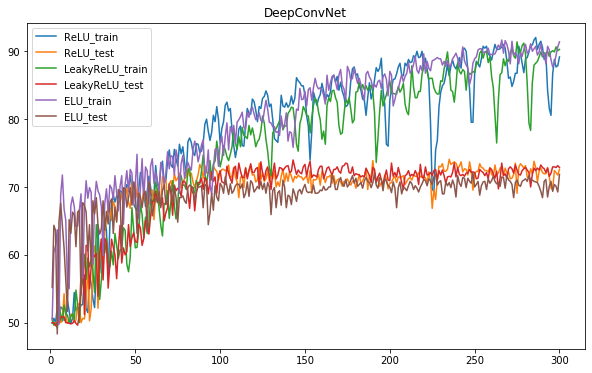

In [10]:
figure=plot(df)
figure.savefig('deepconvnet result.png')